# Прогнозирование уровня средней заработной платы в России

## Инструкции

In [14]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
wages = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
wages.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. 
Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

## 1. Визуальный анализ ряда

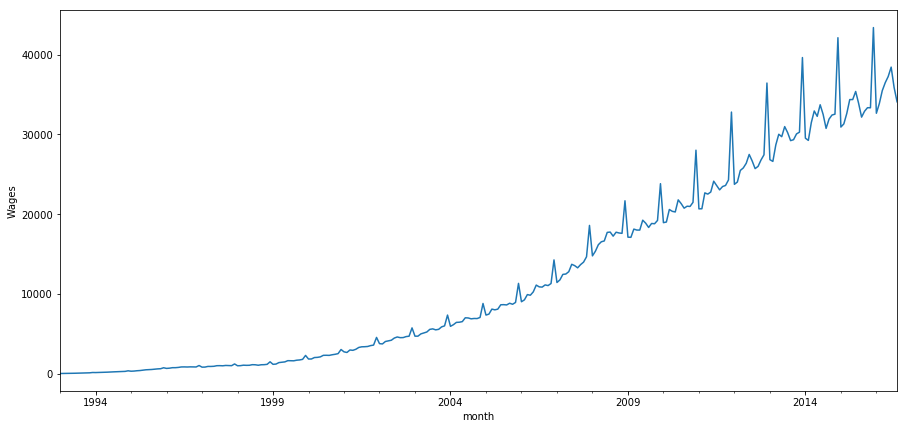

In [3]:
plt.figure(figsize(15,7))
wages.WAG_C_M.plot()
plt.ylabel('Wages')
pylab.show()

**Комментарий**: Ярко выражен тренд на повышение. Кроме того, присутствует сезонность: наименьшее значение в январе, летний пик, далее спад и снова пик в декабре, после чего снова спад. 

**Проверка стационарности и STL-декомпозиция ряда.**

Критерий Дики-Фуллера: p=0.991850


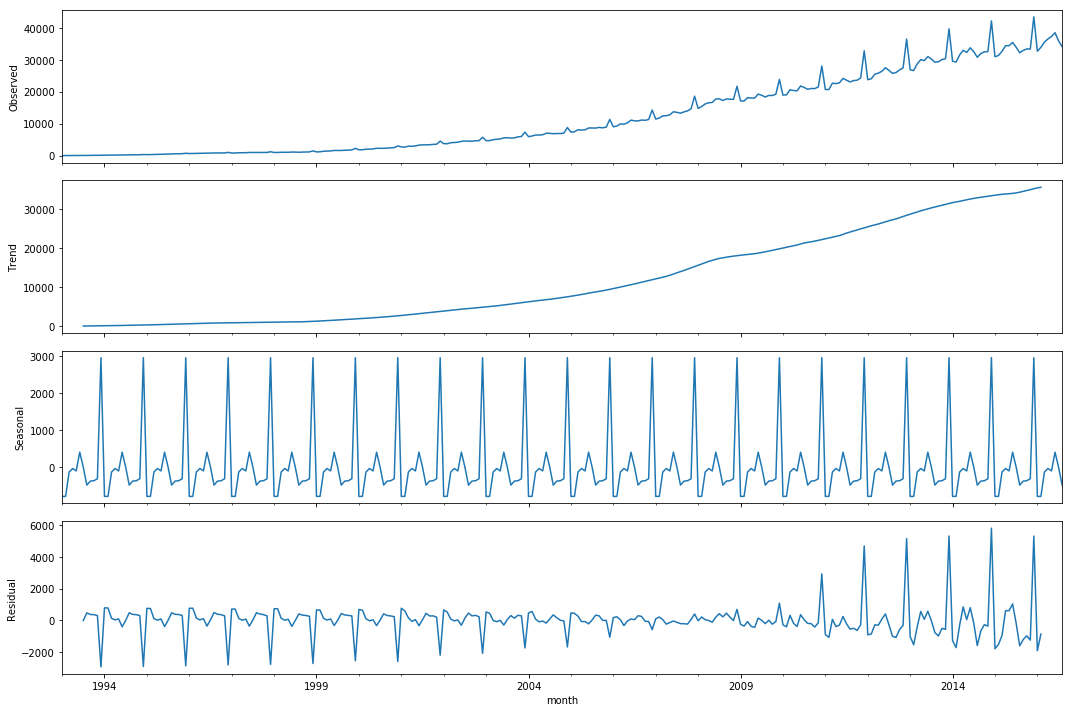

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.WAG_C_M)[1])

**Комментарий**: Критерий Дики-Фуллера гипотезу о нестационарности не отвергает (~0.1 > 0.05), этот же факт подтверждает визуальный анализ данных. Можно сделать следующий вывод: временной ряд не стационарен. Необходима стабилизация.

## 2. Стабилизация дисперсии (при необходимости)

**Комментарий**: Декабрьский пик тем ярче выражен, чем он ближе к концу наблюдаемого периода. Необходимо сделать стабилизацию дисперсии.

Обратное преобразование Бокса-Кокса.

In [5]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии.

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


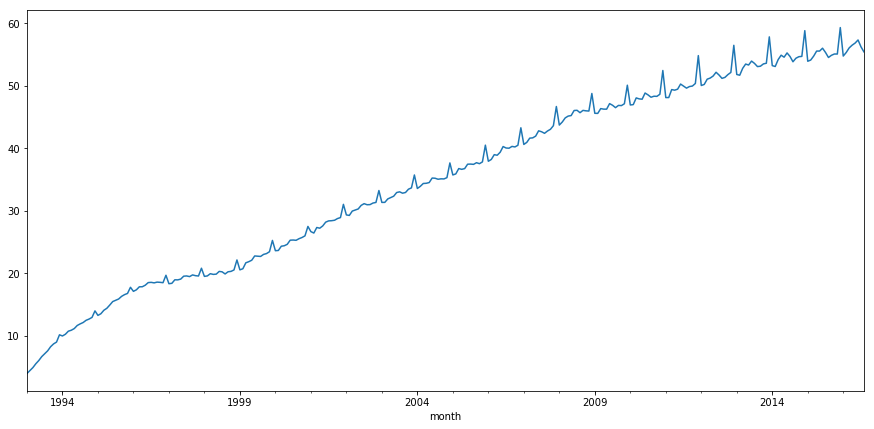

In [6]:
wages['WAG_boxcox'], lmbda = stats.boxcox(wages.WAG_C_M)
plt.figure(figsize(15,7))
wages.WAG_boxcox.plot()
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.WAG_boxcox)[1])

**Комментарий**: Критерий Дики-Фуллера по прежнему не отвергает гипотезу о нестационарности, однако стоит обратить внимаение на то, что значение p-value уменьшилось. По графику изменения значений временного ряда видно, что всё ещё есть и тред, и сезонная составляющая. Поэтому необходимо ряд дифференцировать.

## 3. Выбор порядка дифференцирования

Попробуем **сезонное** дифференцирование. В данном случае сезон = год = 12 месяцев. При наличии наблюдаемой сезонности рекомендуется начинать дифференцирование именно так.

Критерий Дики-Фуллера: p=0.014697


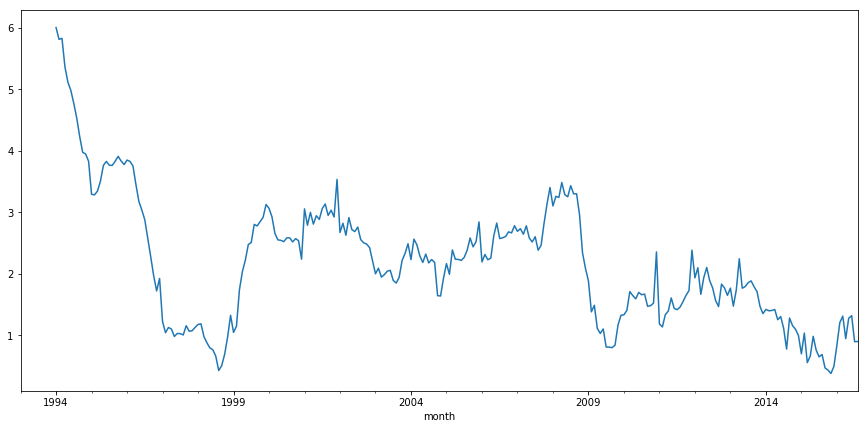

In [7]:
wages['WAG_boxcox_seas'] = wages.WAG_boxcox - wages.WAG_boxcox.shift(12)
plt.figure(figsize(15,7))
wages.WAG_boxcox_seas.plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.WAG_boxcox_seas.dropna())[1])

**Проверка стационарности и STL-декомпозиция ряда.**

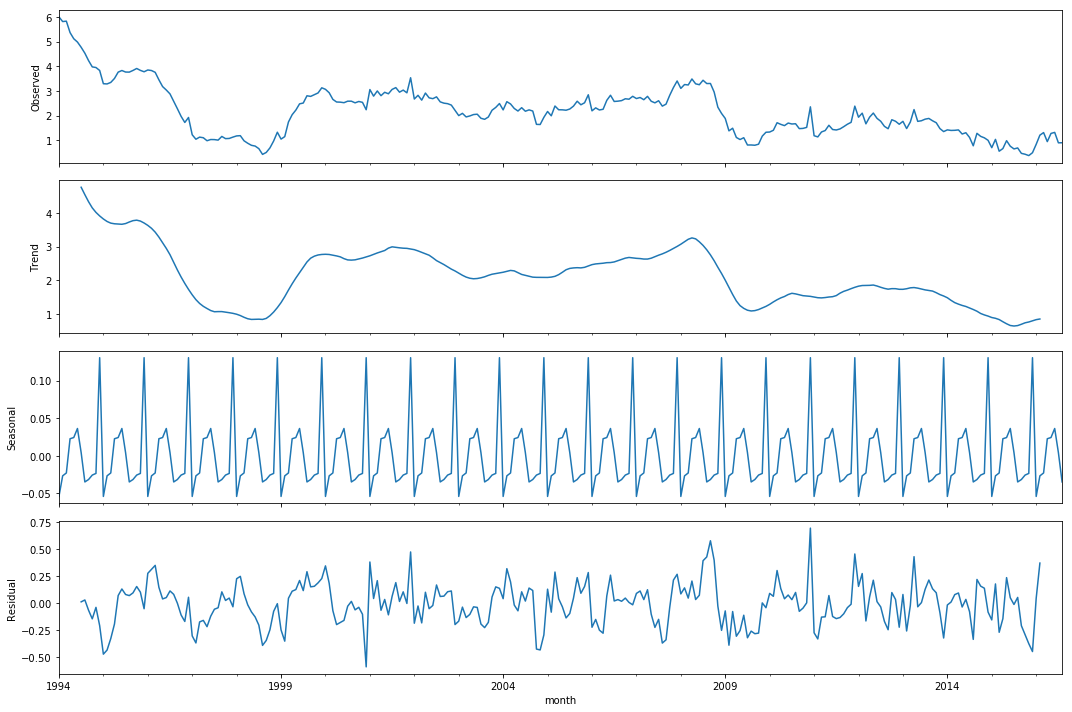

In [8]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.WAG_boxcox_seas.dropna()).plot() 
plt.show()

**Комментарий**: Критерий Дики-Фуллера формально отвергает гипотезу о нестационарности ряда. Но тренд всё ещё присутствует: на тех промежутках времени, где на графике тренда первоначальных данных наблюдалось замедление роста значений, теперь наблюдаются спад и затем подъём. 

Попробуем **обычное** дифференцирование.

Критерий Дики-Фуллера: p=0.000000


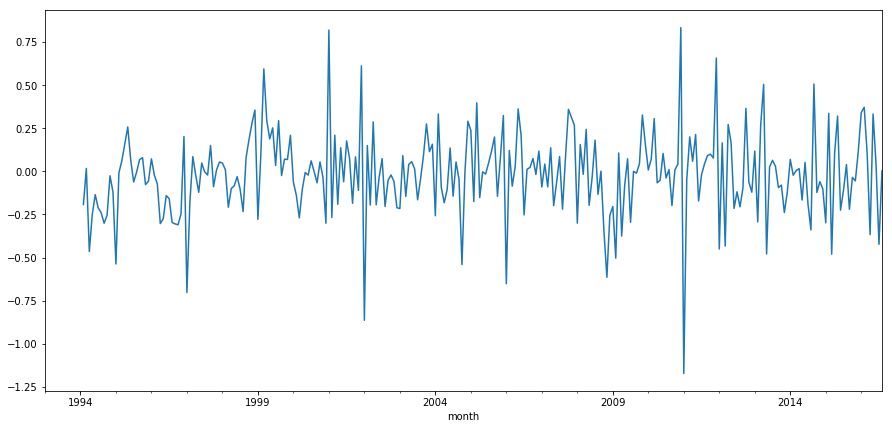

In [9]:
wages['WAG_boxcox_diff'] = wages.WAG_boxcox_seas - wages.WAG_boxcox_seas.shift(1)
plt.figure(figsize(15,7))
wages.WAG_boxcox_diff.plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wages.WAG_boxcox_diff.dropna())[1])

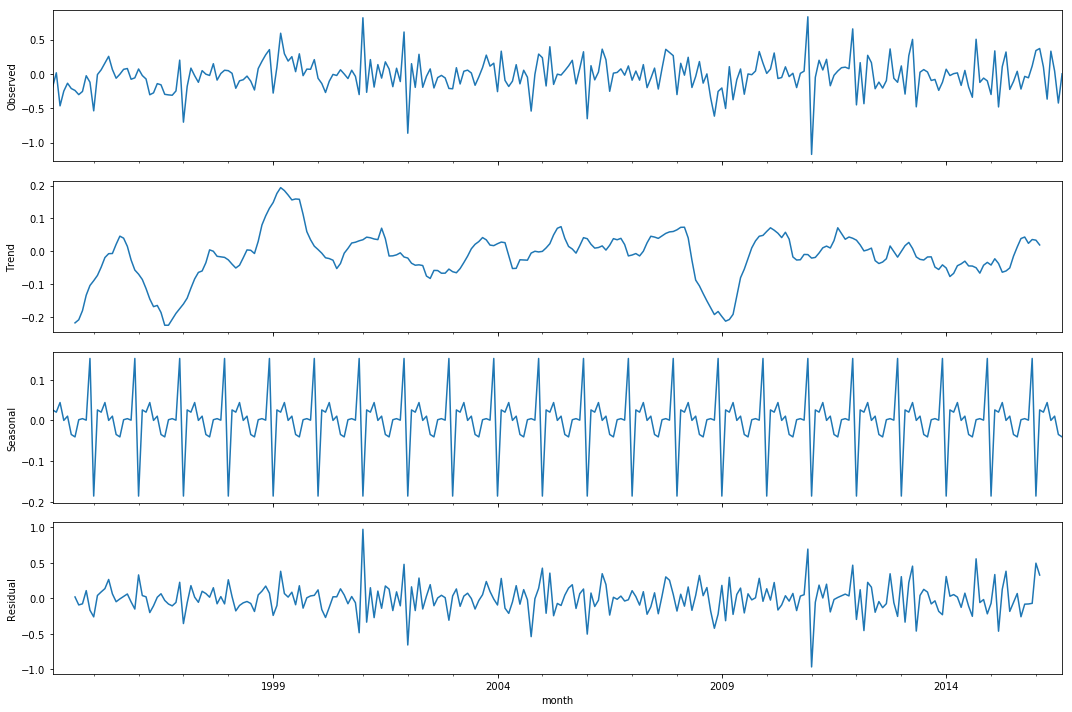

In [10]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wages.WAG_boxcox_diff.dropna()).plot() 
plt.show()

**Комментарий**: Теперь по критерию Дики-Фуллера гипотеза о нестационарности ряда может быть отвергнута с ещё бОльшей уверенностью. Тренда больше нет.

## 4. Выбор начальных приближений для $p,q,P,Q$

Начальные приближения $q, Q$ определяются по графику **автокорреляционной** функции.  
**$Q*S, S=12$** -  номер последнего сезонного лага, при котором автокорреляция значима  
**$q$** - номер последнего несезонного лага, при котором автокорреляция значима

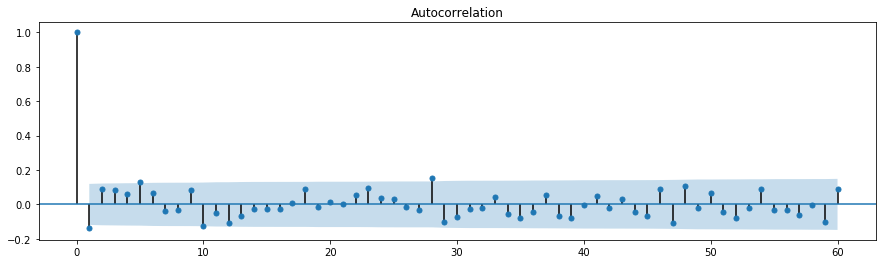

In [11]:
plt.figure(figsize(15,4))
sm.graphics.tsa.plot_acf(wages.WAG_boxcox_diff.dropna(), lags=60)
pylab.show()

В случае $Q$ исследуем лаги: 0, 12, 24, 36, 48 и 60. Только в 0 функция автокорреляции значима. Следовательно, $Q_{start} = 0$  
В случае $q$ исследуем лаги: 0,1, ..., 11. Последний момент, в котором функция автокорреляции значима, это 5. Следовательно, $q_{start} = 5$. Рассматриваем лаги < S, так как при бОльших значениях $q$ модель получилась бы, во-первых, слишком большой, а, во-вторых, неоднозначно определённой: некоторые шумы ($\epsilon$) входили бы и в сезонную, и в несезонную компоненты.

Начальные приближения $p, P$ определяются по графику **частичной автокорреляционной** функции.  
**$P*S, S=12$** -  номер последнего сезонного лага, при котором частичная автокорреляция значима  
**$p$** - номер последнего несезонного лага, при котором частичная автокорреляция значима

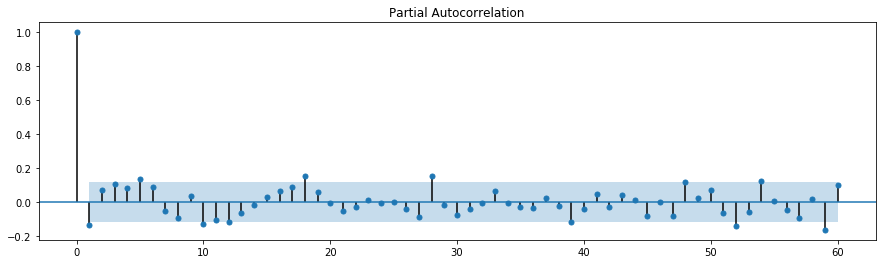

In [12]:
plt.figure(figsize(15,4))
sm.graphics.tsa.plot_pacf(wages.WAG_boxcox_diff.dropna(), lags=60)
pylab.show()

В случае $P$ исследуем лаги: 0, 12, 24, 36, 48 и 60. В 48 функция частичной автокорреляции значима. Следовательно, $P_{start} = 4$  
В случае $p$ исследуем лаги: 0,1, ..., 11. Последний момент, в котором функция автокорреляции значима, это 10. Следовательно, $p_{start} = 10$  

_заметка себе на будущее_: нужно было выбрать $p_{start} = 5$, 10 всё же не достаточно явно выходит из границ незначимости. это не говоря уже о том, что перебирать наборов пришлось бы меньше, да и первоначальное приближение было бы ближе к результату.

Начальное приближение: $(p,q,P,Q)=(10,5,4,0)$

## 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [23]:
ps = range(0, 11)
d=1 # один раз дифференцируется обычно
qs = range(0, 6)
Ps = range(0, 5)
D=1 # один раз дифференцируется сезонно
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

660

**Комментарий**: Сравнивать разные модели будем по информационному **критерию Акаике**.

In [26]:
%%time # C 660 наборами ДОЛГО РАБОТАЕТ!!!!!!
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
num_of_fails=0;

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wages.WAG_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])    
warnings.filterwarnings('default')

print ("Из %d модель обучилась на %d наборах",(len(parameters_list), len(parameters_list)-num_of_fails))

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (1, 2, 2, 0))
('wrong parameters:', (1, 2, 2, 1))
('wrong parameters:', (1, 2, 3, 0))
('wrong parameters:', (1, 2, 3, 1))
('wrong parameters:', (1, 2, 4, 0))
('wrong parameters:', (1, 2, 4, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 2, 1))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 3, 1))
('wrong parameters:', (2, 1, 4, 0))
('wrong parameters:', (2, 1, 4, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (2, 2, 2, 0))
('wrong parameters:', (2, 2, 2, 1))
('wrong parameters:', (2, 2,

In [27]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
228  (5, 5, 4, 1) -27.374202
268  (6, 5, 4, 1) -26.912414
221  (5, 5, 1, 0) -25.936698
220  (5, 5, 0, 1) -25.393573
223  (5, 5, 2, 0) -24.648709


**Комментарий**: Наилучшей является модель с наименьшим значением критерия Акаике (aic). В нашем случае это $(p,q,P,Q)=(5,5,4,1)$. Стоит отметить, что абсолютное значение AIC не имеет смысла — он указывает только на относительный порядок сравниваемых моделей.

**Посмотрим на лучшую модель**

In [28]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         WAG_boxcox   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(4, 1, 1, 12)   Log Likelihood                  29.687
Date:                            Fri, 21 Jul 2017   AIC                            -27.374
Time:                                    14:19:41   BIC                             31.009
Sample:                                01-01-1993   HQIC                            -3.967
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0317      1.743      0.018      0.985      -3.385       3.448
ar.L2          0.0346      1.270   

**Комментарий**: Достигаемый уровень значимости Prob(Q) достаточно большой. То есть, по всей видимости, остатки модели не автокоррелированы. Переходим к их анализу.

## 6. Анализ остатков построенной модели, при необходимости — её модификация

Остатки -- это разность между фактом и прогнозом. Остатки оценивают шумовую компоненту: то, что наблюдать невозможно. Мы делаем некоторые предположения об остатках: **1)** несмещённость (проверяется стандартным одновыборочным критерием Стьюдента или Уилкоксона) || если это не так, то что-то капитально неверно **2)** стационарность = независимость от времени (проверяется криетрием Дики-Фуллера) || если это не так, то это значит, что модель не одинакова точна в разные периоды **3)** неавтокоррелированность = отсутствие неучтённой зависимости от предыдущих наблюдений (можно проверить по кореллограмме или с помощью Q-критерия Льюнга-Бокса) || если это не так, то есть ещё какая-то информация и модель можно усложнить

**1)** Несмещённость.  

In [45]:
stats.ttest_1samp(best_model.resid.dropna(), 0)

Ttest_1sampResult(statistic=0.87029676495575481, pvalue=0.38487584261801799)

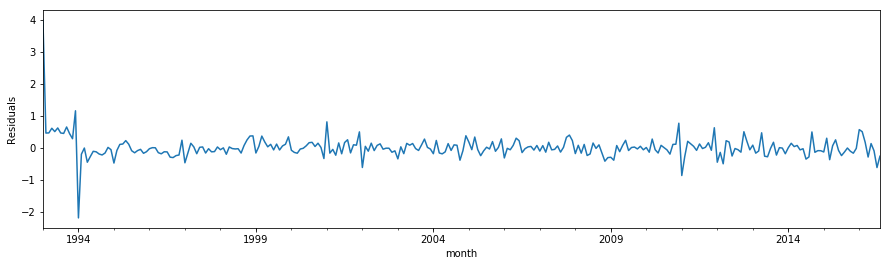

In [47]:
plt.figure(figsize(15,4))
best_model.resid.dropna().plot()
plt.ylabel(u'Residuals')
plt.show()

**Комментарий**: Остатки несмещены

**2)** Стационарность

In [46]:
sm.tsa.stattools.adfuller(best_model.resid.dropna())

(-20.731009750638759,
 0.0,
 0,
 283,
 {'1%': -3.4536701635927378,
  '10%': -2.5722411158835796,
  '5%': -2.8718077069772248},
 -59.564369627792416)

**Комментарий**: Остатки стационарны

**3)** Неавтокоррелированность

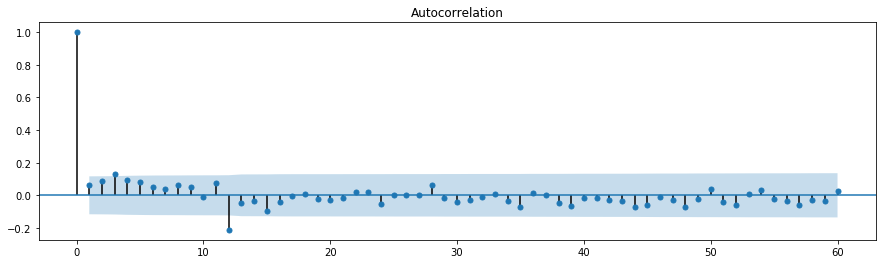

In [50]:
plt.figure(figsize(15,4))
sm.graphics.tsa.plot_acf(best_model.resid.dropna(), lags=60)
plt.show()

**Комментарий**: Единичный выброс на 12ом лаге можно объяснить эффектом множественной проверки гипотез. Учитвая ещё значение 
Q-критерия Льюнга-Бокса $Ljung-Box (Q) : 29.82$, остатки можно считать неавтокоррелированными.

**Посмотрим как работает модель**

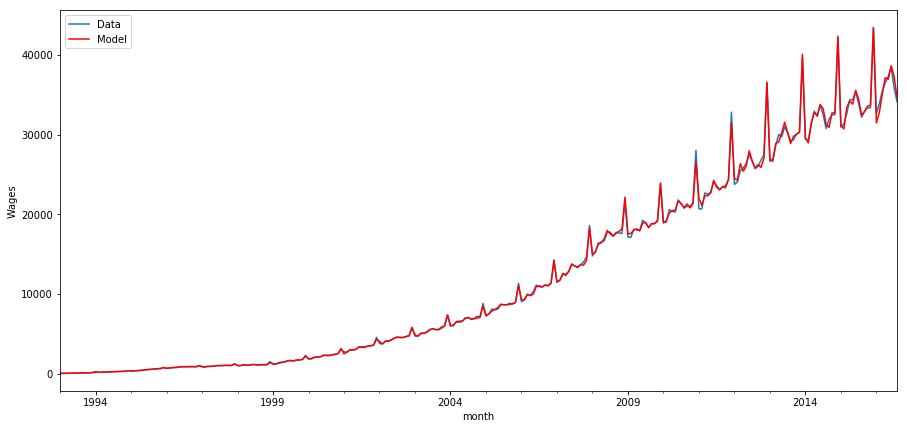

In [51]:
wages['WAG_model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wages.WAG_C_M.plot(label='Data')
wages.WAG_model.dropna().plot(color='r',label='Model')
plt.ylabel('Wages')
plt.legend()
pylab.show()

## 7. Прогнозирование с помощью финальной модели.

Прогноз модели

In [55]:
forecast = invboxcox(best_model.forecast(steps=24),lmbda)

Дополнительные данные для сравнения (из интереса). http://sophist.hse.ru/exes/tables/WAG_M.htm

In [62]:
additional_data = pd.Series(data=[35843.0, 35749.0, 36195.0, 47554.0, 35369.0, 35845.0, 38483.0, 39839.0, 40229.0, 41640.0],index=forecast.index[0:10])

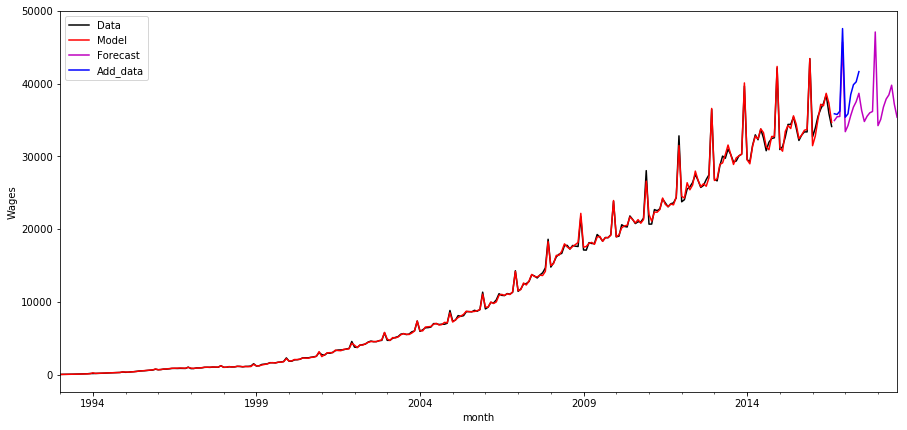

In [67]:
plt.figure(figsize(15,7))
wages.WAG_C_M.plot(color='k',label='Data')
wages.WAG_model.dropna().plot(color='r',label='Model')
forecast.plot(color='m',label='Forecast')
additional_data.plot(color='b',label='Add_data')
plt.ylabel('Wages')
plt.legend()
pylab.show()

Поподробней

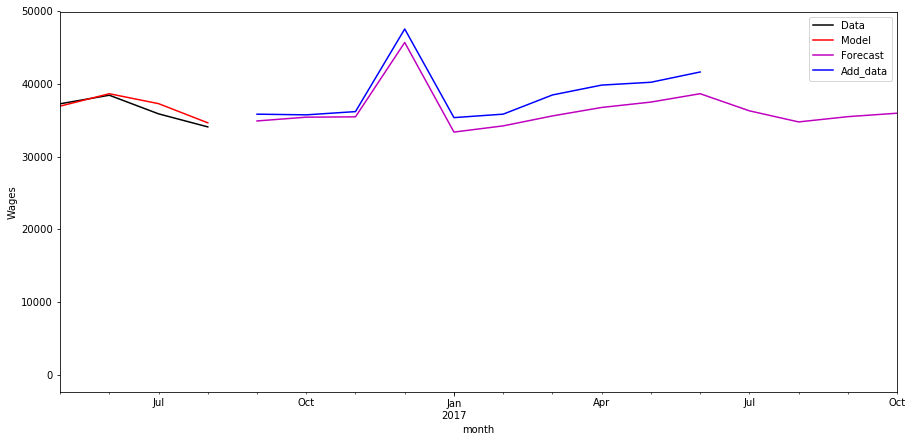

In [66]:
plt.figure(figsize(15,7))
wages.WAG_C_M.plot(color='k',label='Data')
wages.WAG_model.dropna().plot(color='r',label='Model')
forecast.plot(color='m',label='Forecast')
additional_data.plot(color='b',label='Add_data')
plt.ylabel('Wages')
plt.legend()

pylab.xlim(['2016-05-01','2017-10-01'])
pylab.show()

**Комментарий**: Из визуального анализа можно заключить, что модель работает довольно хорошо.

# Замечания к работе

Автор: Ольга Андриевская (coursera user)  
Ставлю полный балл, но есть замечания.
1. Параметр q нужно было выбрать 10, этот лаг тоже значимый, а речь идет о начальном приближении.
2. Бокс-Кокс с автоматическим подбором лямбда не дает хороших результатов - дисперсию от не стабилизировал. лямда=0 (обычное логарифмирование) убирает нестабильность почти полностью.
3. Точность модели получилась не очень хорошая. Возможно, следовало обрезать ряд.